In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LumiNet/images/imgpair #추론한 결과가 있는 디렉토리 / on, off, output 3개의 쌍이 필요

#폴더구조 imgpair
            # ㄴlamp
                # ㄴ1
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet
                # ㄴ2
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet
            # ㄴpendant
                # ㄴ1
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet
                # ㄴ2
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet
            # ㄴstand
                # ㄴ1
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet
                # ㄴ2
                    # ㄴoff.jpg, on.jpg, output_white, output_LumiNet

/content/drive/MyDrive/LumiNet_Files/LumiNet-choi/images/imgpair


In [ ]:
!pip install lpips torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00


LPIPS 모델 로딩 중... (Device: cuda)
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
'.' 경로 하위의 모든 폴더를 검색합니다...
[stand/09] RMSE: 0.0578 | LPIPS: 0.1005
[stand/02] RMSE: 0.0482 | LPIPS: 0.0869
[stand/04] RMSE: 0.0194 | LPIPS: 0.0388
[stand/01] RMSE: 0.0888 | LPIPS: 0.2168
[stand/03] RMSE: 0.0408 | LPIPS: 0.1071
[stand/05] RMSE: 0.0510 | LPIPS: 0.4361
[stand/06] RMSE: 0.0788 | LPIPS: 0.0694
[stand/07] RMSE: 0.0559 | LPIPS: 0.3339
[stand/08] RMSE: 0.0345 | LPIPS: 0.3652
[stand/10] RMSE: 0.0391 | LPIPS: 0.0844
[stand/100] RMSE: 0.0539 | LPIPS: 0.1680
[stand/14] RMSE: 0.0465 | LPIPS: 0.3425
[stand/13] RMSE: 0.0271 | LPIPS: 0.0607
[stand/11] RMSE: 0.0574 | LPIPS: 0.0872
[stand/12] RMSE: 0.0623 | LPIPS: 0.0832
[stand/15] RMSE: 0.0448 | LPIPS: 0.0823
[stand/18] RMSE: 0.0673 | LPIPS: 0.5981
[stand/17] RMSE: 0.0533 | LPIPS: 0.2951
[stand/16] RMSE: 0.0421 | LPIPS: 0.0555
[stand/19] RMSE: 0.0

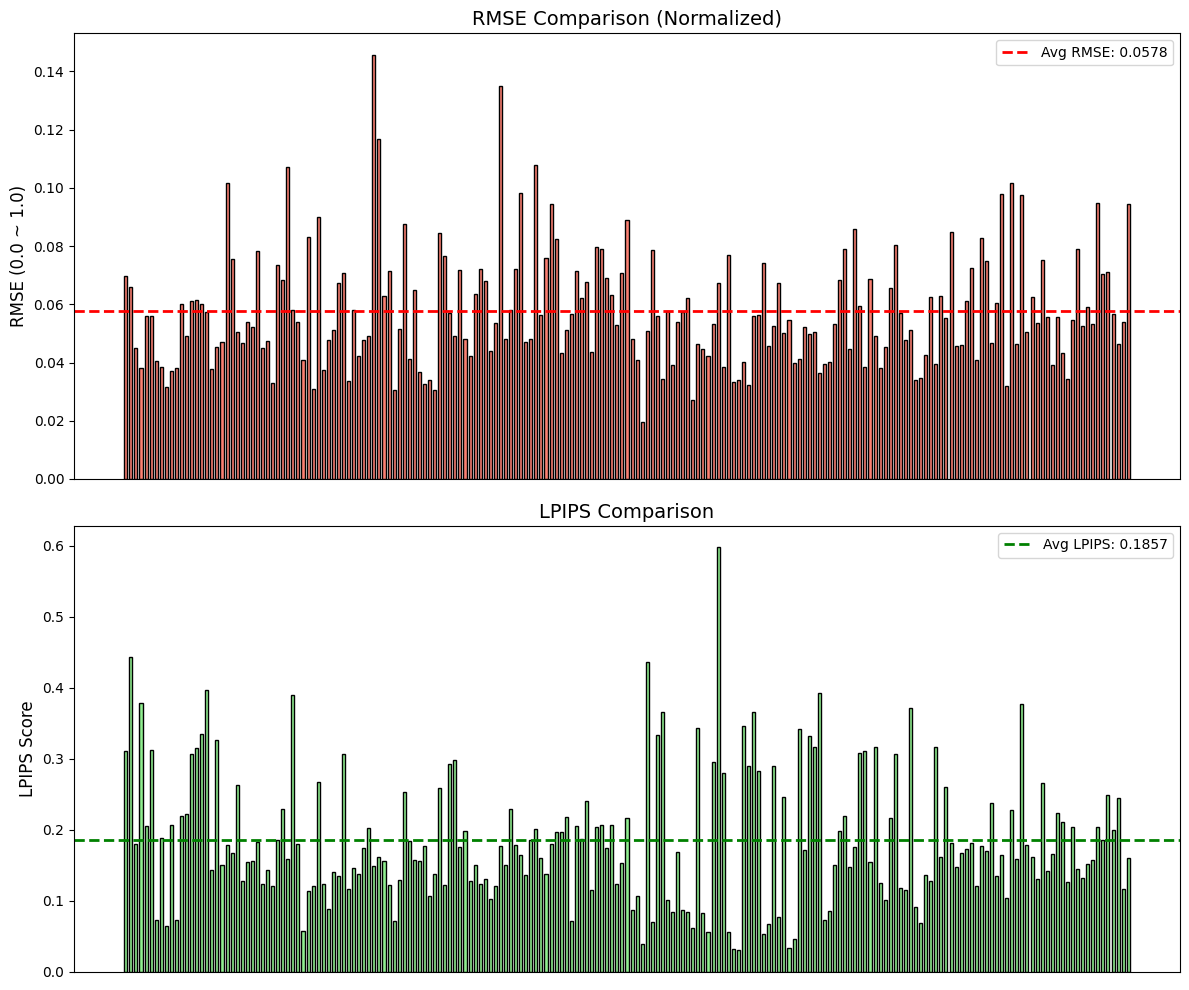

In [ ]:
'''
Experiment_LPIPS.ipynb는 Lumiply가 추론한 결과물이 실제값인 'on'과 얼마나 유사한지 평가하는 노트북입니다.
본 노트북에서는 output과 on을 LPIPS와 RMSE로 평가하며 LPIPS는 두 이미지의 feature가 얼마나 유사한지 RMSE는 두 이미지의 픽셀유사도를 측정하는 지표입니다.
두 지표 모두 낮을수록 유사하다고 평가하며 측정 후 그래프까지 한번에 출력하여 수치를 한눈에 확인할 수 있습니다.
'''


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import lpips

# GPU 사용 가능 여부 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# LPIPS 모델 초기화
print(f"LPIPS 모델 로딩 중... (Device: {device})")
loss_fn_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_metrics_normalized(base_path="."): #각 페어에 대한 RMSE와 LPIPS를 계산하는 함수
    results_rmse = {}
    results_lpips = {}

    print(f"'{base_path}' 경로 하위의 모든 폴더를 검색합니다...")

    for root, dirs, files in os.walk(base_path): #base_path의 모든 하위 디렉토리를 검색합니다
        path_on = None
        path_white = None

        for file in files:
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')): #이미지파일만 불러오기
                continue
            if "on" in file:
                path_on = os.path.join(root, file) #on 파일
            elif "output_white" in file:
                path_white = os.path.join(root, file) #output 파일

        if path_on and path_white:
            try:
                folder_name = os.path.relpath(root, base_path)

                # 이미지 로드 (BGR, 0~255)
                img_on = cv2.imread(path_on)
                img_white = cv2.imread(path_white)

                # 크기 맞추기
                if img_on.shape != img_white.shape:
                    img_white = cv2.resize(img_white, (img_on.shape[1], img_on.shape[0]))

                # --- RMSE 계산 (0~1 범위로 정규화) ---
                # 1. 0~255 정수 데이터를 0.0~1.0 실수 데이터로 변환
                img_on_norm = img_on.astype(np.float32) / 255.0
                img_white_norm = img_white.astype(np.float32) / 255.0

                # 2. 정규화된 데이터로 RMSE 계산 ( on vs output )
                diff = img_on_norm - img_white_norm # 정규화된 두 이미지의 픽셀유사도 계산
                rmse_score = np.sqrt(np.mean(diff ** 2))
                results_rmse[folder_name] = rmse_score

                # --- LPIPS 계산 --- ( on vs output )
                img_on_rgb = cv2.cvtColor(img_on, cv2.COLOR_BGR2RGB)
                img_white_rgb = cv2.cvtColor(img_white, cv2.COLOR_BGR2RGB)

                tensor_on = lpips.im2tensor(img_on_rgb).to(device) # CNN을 통해 feature 추출
                tensor_white = lpips.im2tensor(img_white_rgb).to(device) # CNN을 통해 feature 추출

                with torch.no_grad():
                    lpips_score = loss_fn_lpips(tensor_on, tensor_white) # feature 유사도 계산

                l_score = lpips_score.item()
                results_lpips[folder_name] = l_score

                print(f"[{folder_name}] RMSE: {rmse_score:.4f} | LPIPS: {l_score:.4f}")

            except Exception as e:
                print(f"[{folder_name}] 에러 발생: {e}")

    return results_rmse, results_lpips

# 1. 계산 실행
data_rmse, data_lpips = calculate_metrics_normalized()

# 2. 각 페어별로 RMSE, LPIPS 그래프 그리기
if data_rmse and data_lpips:
    sorted_keys = sorted(data_rmse.keys())
    scores_rmse = [data_rmse[k] for k in sorted_keys]
    scores_lpips = [data_lpips[k] for k in sorted_keys]

    avg_rmse = sum(scores_rmse) / len(scores_rmse)
    avg_lpips = sum(scores_lpips) / len(scores_lpips)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # --- RMSE 그래프 ---
    ax1.bar(sorted_keys, scores_rmse, color='salmon', edgecolor='black', width=0.6)
    ax1.axhline(y=avg_rmse, color='red', linestyle='--', linewidth=2, label=f'Avg RMSE: {avg_rmse:.4f}')
    ax1.set_ylabel('RMSE (0.0 ~ 1.0)', fontsize=12)
    ax1.set_title('RMSE Comparison (Normalized)', fontsize=14)
    ax1.legend()
    ax1.set_xticks([])

    # --- LPIPS 그래프 ---
    ax2.bar(sorted_keys, scores_lpips, color='lightgreen', edgecolor='black', width=0.6)
    ax2.axhline(y=avg_lpips, color='green', linestyle='--', linewidth=2, label=f'Avg LPIPS: {avg_lpips:.4f}')
    ax2.set_ylabel('LPIPS Score', fontsize=12)
    ax2.set_title('LPIPS Comparison', fontsize=14)
    ax2.legend()
    ax2.set_xticks([])

    plt.tight_layout()
    plt.show()
else:
    print("\n[알림] 이미지 쌍을 찾지 못했습니다.")